In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


warnings.filterwarnings("ignore")
        
#/kaggle/input/data-set-merchandise/DataSetMerchandise.csv

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df= pd.read_csv('/kaggle/input/data-set-merchandise/DataSetMerchandise.csv')

In [3]:
df.head()

,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city
0,8533875475515924645,1,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,desktop,Australia,Sydney
1,4874599869430831185,2,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,mobile,Turkey,Istanbul
2,361954421372951638,1,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,desktop,Russia,Moscow
3,8751850432978942600,2,20170205,1.0,1,1.0,NaN,NaN,NaN,bing,Organic Search,Edge,desktop,United States,not available in demo dataset
4,2451058030378352110,1,20170205,1.0,1,1.0,NaN,NaN,NaN,(direct),Organic Search,Chrome,desktop,Indonesia,not available in demo dataset


In [4]:
df.shape


(392892, 15)

In [5]:
df.isnull().sum()

fullVisitorID              0
visitNumber                0
date                       0
bounces               196928
hits                       0
pageviews                 36
timeOnSite            196493
transactionRevenue    387615
transactions          387615
source                     0
channelGrouping            0
browser                    0
deviceCategory             0
country                    0
city                       0
dtype: int64

In [6]:
#La base tiene muchos valores faltantes,cada columna parece importante por ahora, cambiamos los Nan a 0.
#Con 0 esta bien porque todas las columnas con valores de Nan son numericas

df = df.fillna(0)

In [7]:
#Bounce rate =

(df[df['bounces']==1]).shape[0]/(df.shape[0])

0.4987731997597304

<AxesSubplot:xlabel='transactionRevenue'>

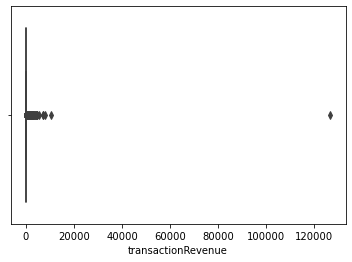

In [8]:
#letr intenta identificar valores atípicos
x=df.groupby(['fullVisitorID'])['transactionRevenue'].sum().sort_values(ascending=False)
sns.boxplot(x=x)

In [9]:
x.iloc[0:3]

fullVisitorID
1957458976293878100    126567.31
4471415710206918415     10465.10
9026840718082010040      7799.60
Name: transactionRevenue, dtype: float64

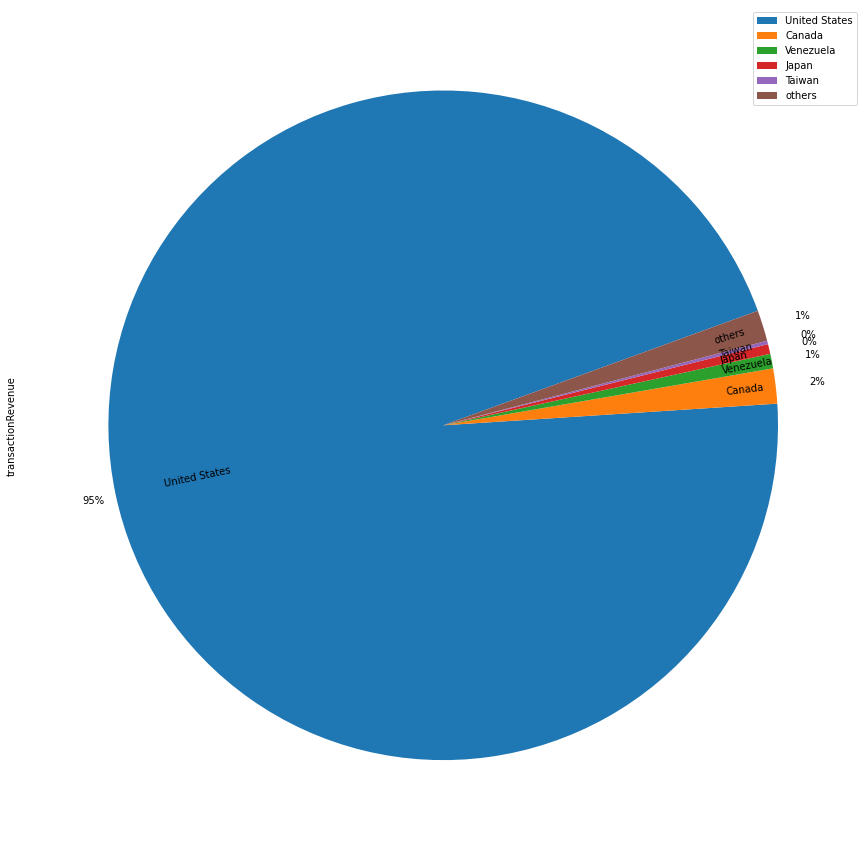

In [10]:
#Comprobando los países con la mayoría de los ingresos totales

country_revenue = df.groupby(['country'])['country','transactionRevenue'].sum().reset_index()
country_revenue = pd.DataFrame(country_revenue)
country_revenue = country_revenue.loc[~((country_revenue['transactionRevenue'] == 0))]  
country_revenue = country_revenue.sort_values(by=['transactionRevenue'], ascending=False)

#Los 5 mejores

top_5 = country_revenue[:5].copy()

#otros

new_row = pd.DataFrame(data = {
    'country' : ['others'],
    'transactionRevenue' : [country_revenue['transactionRevenue'][5:].sum()]})


#combinando los 5 mejores con otros

country_revenue = pd.concat([top_5, new_row])

#plotting --

country_revenue.plot(kind = 'pie',
                     y = 'transactionRevenue',
                     labels = country_revenue['country'],
                     autopct='%1.0f%%',
                     pctdistance=1.1,
                     labeldistance=0.85,
                     rotatelabels =True,
                     textprops = dict(rotation_mode = 'anchor', va='center', ha='left'),
                     figsize=(15, 25),
                     startangle=20)
plt.xticks(rotation=20)
plt.show()

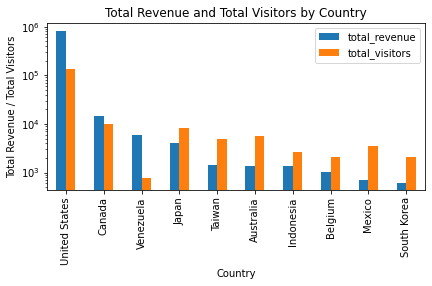

In [11]:
#agrupe los datos por país.
#calcule los ingresos totales y el número total de visitantes para cada país

country_group = df.groupby('country').agg({'transactionRevenue': 'sum', 'fullVisitorID': 'nunique'})

country_group = country_group.rename(columns={'transactionRevenue': 'total_revenue', 'fullVisitorID': 'total_visitors'})

country_group = country_group.sort_values(by='total_revenue', ascending=False)

country_group = country_group.query('total_revenue != 0')

top_15 = country_group[:10].copy()

top_15.plot(kind='bar', y=['total_revenue', 'total_visitors'], stacked=False)


# set x-axis label
plt.xlabel('Country')

# set y-axis label
plt.ylabel('Total Revenue / Total Visitors')

# set title
plt.title('Total Revenue and Total Visitors by Country')

plt.semilogy()

plt.subplots_adjust(bottom=0.3,right=1)
# show plot
plt.show()

In [12]:
#cambiando la fecha del formato para manipularlo
df['date']= df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [13]:
#ingresos mensuales
monthly_rev = df.set_index('date').resample('M')["transactionRevenue"].sum().reset_index()
monthly_rev.head(7)

#visitas mensuales
monthly_vis = df.set_index('date').resample('M')["fullVisitorID"].count().reset_index()

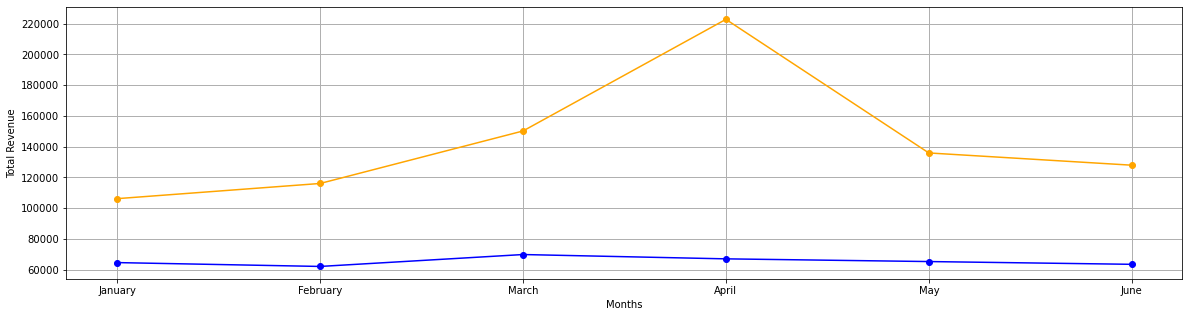

In [14]:
#ingresos por trazado por mes y visitantes por mes

months = ["January", "February", "March", "April", "May","June"]

plt.figure(figsize=(20,5))
plt.xlabel("Months")
plt.ylabel("Total Revenue")
plt.plot(months, monthly_rev.loc[:,'transactionRevenue'],"ro",linestyle="solid", color = "orange")
plt.plot(months, monthly_vis.loc[:,'fullVisitorID'],"ro",linestyle="solid", color = "blue")
plt.grid(linewidth = 1)

<AxesSubplot:ylabel='channelGrouping'>

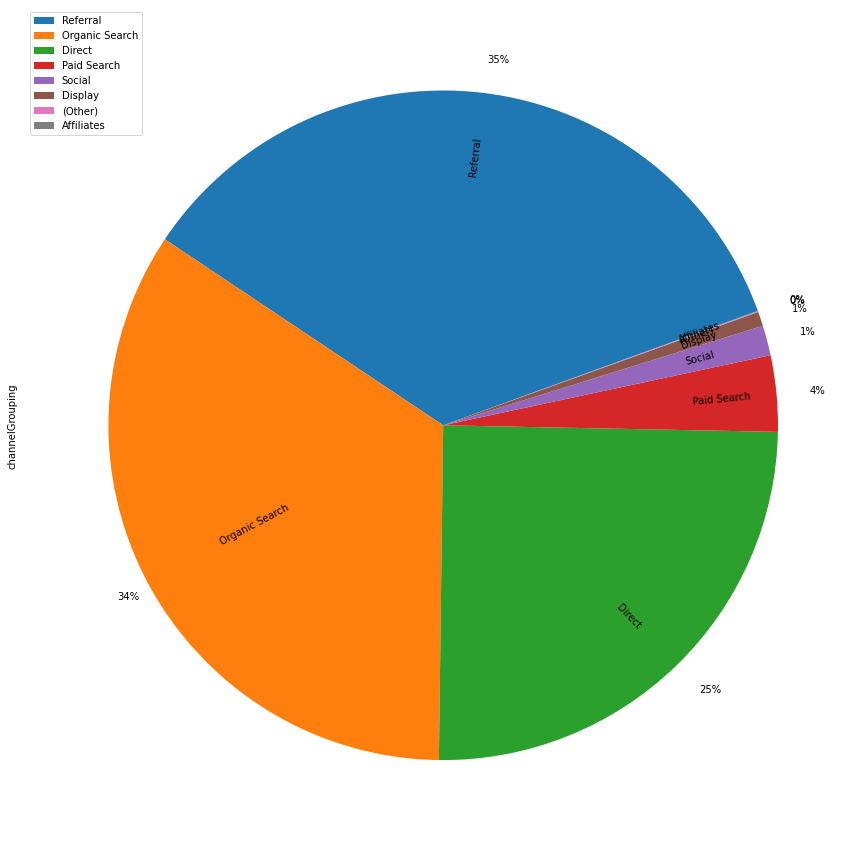

In [15]:
#el origen de las personas que terminaron convirtiéndose.
 
# identificar usuarios para los cuales hay al menos una transacción

keep = df['transactionRevenue'].ne(0).groupby(df['fullVisitorID']).any()

# mantener a esos usuarios

m1 = df['fullVisitorID'].isin(keep[keep].index)

# verifique de dónde vinieron por primera vez

m2 = df['visitNumber'].eq(1)

# obtener la proporción de cada fuente

grouping = df.loc[m1&m2, 'channelGrouping'].value_counts(normalize=True).reset_index()
grouping.plot(kind = 'pie',
              y = 'channelGrouping',
              labels = grouping['index'],
              autopct='%1.0f%%',
              pctdistance=1.1,
              labeldistance=0.75,
              rotatelabels =True,
              textprops = dict(rotation_mode = 'anchor', va='center', ha='left'),
              figsize=(15, 25),
              startangle=20)

<AxesSubplot:xlabel='visitNumber', ylabel='amount of transactions'>

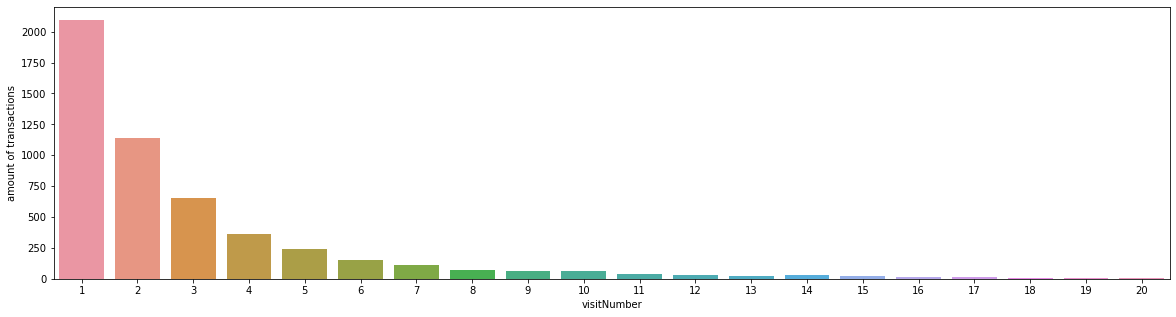

In [16]:
# ¿Existe alguna relación entre el número de visita y la conversión??
cond_1 = df['transactionRevenue'].ne(0)
m2 = df.loc[cond_1, ['visitNumber']].groupby(['visitNumber']).size().reset_index(name='amount of transactions')

#plotting

m2['visitNumber'] = m2['visitNumber'].astype(int)
m2 = m2.loc[m2['visitNumber'] <= 20]
plt.figure(figsize=(20,5))
sns.barplot(x=m2['visitNumber'], y=m2['amount of transactions'])

In [17]:
# Dejaré afuera las columnas que creo no ayudarán a predecir si un cliente se convertirá o no.
df2 = df
df2 = df2.drop(['fullVisitorID','date','transactionRevenue'], axis=1)

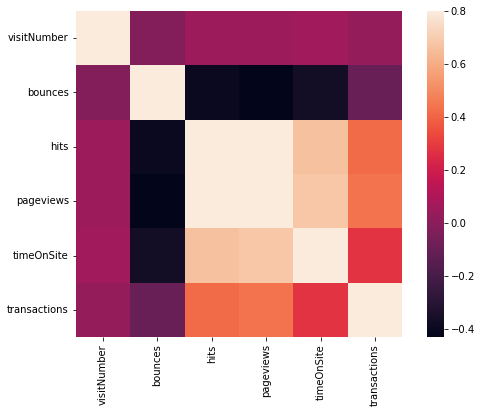

In [18]:
# Matriz de correlación (estilo de mapa de calor)
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(corrmat, vmax=.8, square=True);

In [19]:
# Si vemos los datos relacionados con la página,
#podemos concluir que dan casi la misma información para que realmente ocurra la multicolinealidad
 
# Así que conservemos uno de esos

df2 = df2.drop(['pageviews'], axis=1)

In [20]:
# tenemos que convertir variables categóricas en números. LabelEncoder no parece ser la mejor solución
# procesar estas variables categóricas ya que pone un orden y una jerarquía
 # entre las categorías que no son propias de los datos.

# Así que voy a usar Hot Encoding.


# Pero antes de usar la codificación Hot quiero agrupar a todos los países que no realizaron ninguna transacción.

# grupo por país y transacciones de suma
grouped = df2.groupby('country')['transactions'].sum()
grouped.head()
how_many=0
for index, row in grouped.iteritems():
    # check if the sum of transactions is 0
    if row == 0:
        how_many+=1
        # replace the country name with "Others" in the original dataframe
        df2.loc[df['country'] == index, 'country'] = "Others"
        
print(how_many)

164


In [21]:
# Hubo 164 países que no han realizado ninguna transacción.

In [22]:
from sklearn.preprocessing import OneHotEncoder

# create a one-hot encoder
encoder = OneHotEncoder(sparse=False)

for i in ["country","channelGrouping","browser","deviceCategory","city","source"]:
    i_onehot = encoder.fit_transform(df2[[i]])
    i_df = pd.DataFrame(i_onehot, columns=encoder.get_feature_names([i]))
    i_df.head()
    df2 = df2.join(i_df)
    df2 = df2.drop([i], axis=1) 
    #drop the column
    

In [23]:
df2.shape


(392892, 731)

In [24]:
#la columna de transacciones será mi y, por lo que debe ser binaria, más de 1 transacción: Verdadero, de lo contrario falso.
df2['transactions']=df2['transactions'].apply(lambda x: 1 if x!=0 else 0)

In [25]:
#mi X e y
X = df2.loc[:, df2.columns != 'transactions']
y = df2['transactions']

# He decidido usar un algoritmo forest estándar para modelar mi predictor.
# El forest aleatorio es un algoritmo ideal para lidiar con el desequilibrio extremo debido a dos razones principales. En primer lugar, la capacidad de incorporar pesos de clase. En segundo lugar, combina la técnica de muestreo y el aprendizaje de conjunto, por lo tanto, minimiza la clase mayoritaria y proporciona un conjunto de datos más equilibrado.

In [26]:
#Es importante cuidar el desequilibrio del conjunto de datos: SMOTE utiliza una clase minoritaria para generar muestras sintéticas.
#En consecuencia, supera el problema de exceso de equipamiento planteado por un sobremuestreo aleatorio.

oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y,
                                                                        test_size=0.1, stratify=over_y)

In [27]:
#Construir el modelo SMOTE SRF

SMOTE_SRF = RandomForestClassifier(n_estimators=225, random_state=0)

In [28]:
# Conjunto de datos derramado al azar para probar y entrenar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [29]:
#Train SMOTE SRF

SMOTE_SRF.fit(over_X_train, over_y_train)

RandomForestClassifier(n_estimators=225, random_state=0)

In [30]:
#SMOTE SRF resultado de predicción
y_pred = SMOTE_SRF.predict(X_test)

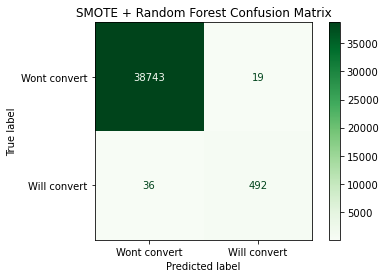

In [31]:
#Crear matriz de confusión
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['Wont convert', 'Will convert'], cmap='Greens')
plt.title('SMOTE + Random Forest Confusion Matrix')
plt.show()

In [32]:
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy score:",accuracy)
precision = metrics.precision_score(y_test, y_pred)
print("Precision score:",precision)
recall = metrics.recall_score(y_test, y_pred) 
print("Recall score:",recall)

Accuracy score: 0.9986001527106134
Precision score: 0.9628180039138943
Recall score: 0.9318181818181818
